# 2D Aircraft Dynamics for Maneuvers

Let's look at a similar problem, but perhaps with some more exciting dynamics.

Suppose we have an [adrenaline-loving wingsuit pilot](https://en.wikipedia.org/wiki/Wingsuit_flying) who wants to race her friend to the bottom of a mountain.

If you haven't seen a wingsuit before, [check out this short video demonstration](https://youtu.be/kTzwvyzzfjk). (Note: yelling "Vive la France" while jumping is a mandatory part of wingsuiting that increases aerodynamic performance.)

## Terrain Generation

Let's make some procedurally-generated mountain. Ignore this part if you just want to focus on AeroSandbox

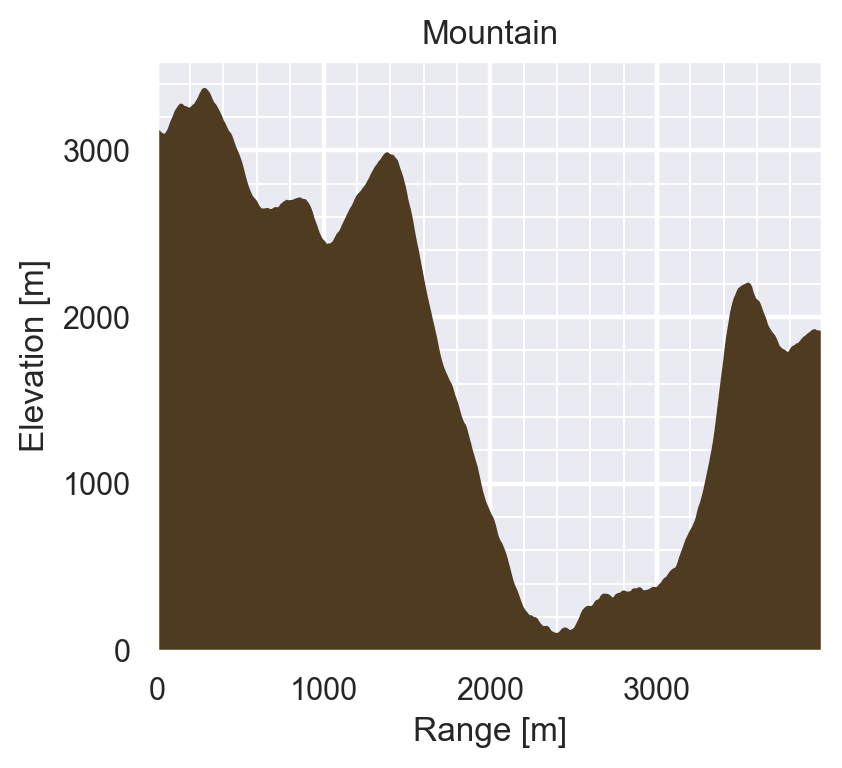

In [245]:
import aerosandbox as asb
import aerosandbox.numpy as np
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p
from scipy import stats


class Mountain:
    color = "#4f3b1f"

    def __init__(self,
                 x_max=4000,
                 resolution=8,  # Note - log-scaled
                 ):
        np.random.seed(5)  # Found by trial and error.

        ### Scary inverse FFT magic below this line, ignore...
        # We are basically just generating random noise with a specific spectral power density
        k = np.arange(2 ** resolution)
        d_omega = 2 * np.pi / len(k)
        omega = d_omega * np.arange(len(k))

        spatial_power = (omega + 1e-16) ** -3.5  # No science behind this -3.5, this PSD just "looks right"
        spatial_power[0] = 0  # Zero the DC-mode power

        spatial_amps = np.sqrt(2 * spatial_power * d_omega)
        spatial_phase = np.random.random(spatial_power.shape) * 2 * np.pi
        spatial_freq_signal = spatial_amps * np.exp(1j * spatial_phase)
        elevation = np.fft.irfft(
            spatial_freq_signal, axis=0
        )
        x = x_max * np.arange(len(elevation)) / len(elevation)

        ### Here, we just add some biases to make it more mountain-y (sloped)
        elevation *= 2000
        elevation += - 0.3 * x
        elevation += stats.norm(1400, 100).pdf(x) * 1e5  # Adds a gaussian "bump"
        elevation += stats.norm(3500, 100).pdf(x) * 1.6e5  # Adds a gaussian "bump"
        elevation += 100 - elevation.min()  # Normalize the elevation so that the minimum elevation is 100 m.

        self.x_data = x
        self.elevation_data = elevation

    def elevation(self, x):
        return np.interp(
            x=x,
            xp=self.x_data,
            fp=self.elevation_data
        )

    def draw(self,
             show=True,
             set_bounds=True,
             set_equal=True,
             set_ticks=True,
             ):
        plt.fill_between(
            self.x_data,
            0,
            self.elevation_data,
            color=self.color
        )
        if set_equal:
            plt.gca().set_aspect("equal", adjustable='box')
        if set_bounds:
            plt.xlim(
                self.x_data.min(),
                self.x_data.max()
            )
            plt.ylim(bottom=0)
        if set_ticks:
            p.set_ticks(1000, 200, 1000, 200)
        if show:
            plt.show()


mountain = Mountain()
mountain.draw(show=False)
p.show_plot("Mountain", "Range [m]", "Elevation [m]")


Let's start our wingsuit pilot at the top of that peak there. Where is it?

In [246]:
x_peak = mountain.x_data[np.argmax(mountain.elevation_data)]
elevation_peak = np.max(mountain.elevation_data)
print(f"Peak is at ({x_peak:.0f}, {elevation_peak:.0f}) meters.")

Peak is at (282, 3369) meters.


## Dynamics

And, let's see how fast we can get to the bottom of this mountain!

In [247]:
### Initialize the problem
opti = asb.Opti()

### Define time.
# Note that in this problem we discretize through x, not time. This is for two reasons:
# a) to demonstrate something different than the previous tutorial
# b) so that we can sample the mountain elevation at fixed x-points, rather than at varying x-points.
time = opti.variable(init_guess=np.linspace(0, 100, 150))
opti.subject_to([
    time[0] == 0,
    np.diff(time) > 0,
])
N = np.length(time)

### Create a dynamics instance

dyn = asb.DynamicsPointMass2DSpeedGamma(
    mass_props=asb.MassProperties(mass=80),
    x_e=np.linspace(x_peak, mountain.x_data.max(), N),
    # Note that x is fixed a priori; we are discretizing along x, not time.
    z_e=opti.variable(np.linspace(-elevation_peak, -mountain.elevation_data[-1], N)),
    speed=opti.variable(init_guess=50, n_vars=N),
    gamma=opti.variable(init_guess=0, n_vars=N, lower_bound=-np.pi / 2, upper_bound=np.pi / 2),
    alpha=opti.variable(init_guess=5, n_vars=N, lower_bound=-30, upper_bound=60),
)
# Constrain the initial state
opti.subject_to([
    dyn.z_e[0] == -elevation_peak,
    dyn.speed[0] == 10,  # How fast can you run off a cliff? :)
    dyn.gamma[0] == np.radians(30)
])

### Add in forces
dyn.add_gravity_force(g=9.81)

### Add in custom lift and drag
S = 1.5  # Roughly 1.5 m^2 area for a wingsuit?
# These are just hand-wavey stand-in models; the point is that you can write your own.
CL = 3 * np.sind(2 * dyn.alpha)
CD = 2 * np.sind(dyn.alpha) ** 2 + 0.4
# Together, these give L/D_max of around 3.1, occuring at alpha = 22 deg. This seems about right for a modern wingsuit.

lift = dyn.op_point.dynamic_pressure() * CL * S
drag = dyn.op_point.dynamic_pressure() * CD * S

dyn.add_force(
    Fx=-drag,  # Remember that wind axes point upwind, so drag needs to be negated
    Fz=-lift,  # Remember that wind axes have z pointing down, so lift needs to be negated
    axes="wind"
)

### Constrain the altitude to be above ground at all times
opti.subject_to([
    dyn.altitude > mountain.elevation(dyn.x_e)
])

### Finalize the problem
dyn.constrain_derivatives(opti, time)  # Apply the dynamics constraints created up to this point

opti.minimize(time[-1])  # Go as far downrange as you can

### Solve it
sol = opti.solve(verbose=False)

### Substitute the optimization variables in the dynamics instance with their solved values (in-place)
dyn.substitute_solution(sol)

C:\ProgramData\Anaconda3\lib\site-packages\casadi\casadi.py:10909: RuntimeWarning: Implicit conversion of symbolic CasADi type to numeric matrix not supported.
This may occur when you pass a CasADi object to a numpy function.
Use an equivalent CasADi function instead of that numpy function.
  warnings.warn("Implicit conversion of symbolic CasADi type to numeric matrix not supported.\n"


DynamicsPointMass2DSpeedGamma instance:
	State variables:
		     x_e: [ 282.35294118  307.25095407  332.148...
		     z_e: [-3369.4100387  -3362.09654328 -3330....
		   speed: [10.         12.07692642 23.43256473 ...
		   gamma: [ 0.52359878 -0.92836443 -0.89037463 ...
	Control variables:
		   alpha: [17.85478773 31.81053061 31.81708559 ...
		    Fx_w: [-4.30908313e+02  5.36989001e+02  2.6...
		    Fz_w: [ 5.64983889e+02  2.13300259e+02 -4.7...

Let's draw the solution:

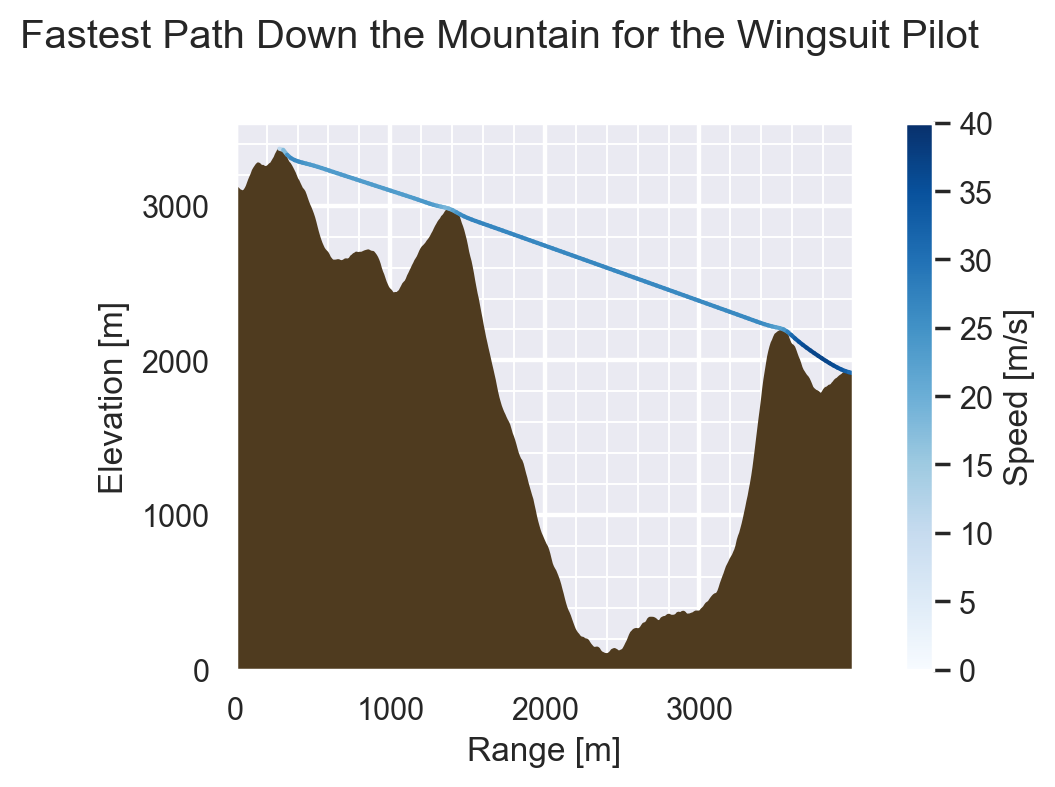

In [248]:
p.plot_color_by_value(
    dyn.x_e, dyn.altitude,
    c=dyn.speed,
    colorbar=True,
    cmap="Blues",
    clim=(0, 40),
    colorbar_label="Speed [m/s]"
)
mountain.draw(show=False)
p.show_plot(
    "Fastest Path Down the Mountain for the Wingsuit Pilot",
    "Range [m]",
    "Elevation [m]",
)

And, our wingsuit pilot can descend from the mountain in:

In [249]:
print(f"{sol.value(time[-1]):.2f} seconds")

156.72 seconds


The solution above makes sense:
* First, we jump off the cliff near $x=300$. We need to point down and accelerate to (near) our best-glide speed, which we quickly reach.
* Next, we focus on the first peak ahead at $x=1400$. We aim just below the peak, and when we get close, we excite a phugoid-mode oscillation that just barely kicks us over the peak.
* We do the same with the second peak at $x=3300$.
* Finally, it's a dead sprint to the finish. We aim at the finish line, right at the terrain so that we can grab as much kinetic energy as possible. Note that the trajectory on this last leg of the flight looks almost like a [Brachistochrone curve](https://en.wikipedia.org/wiki/Brachistochrone_curve). It is not exactly one due to the velocity-dependent drag, but the same general idea applies: better to accelerate early, travel faster, and then slow down when needed at the end to conserve potential energy.